# Xgboost (Extreme Gradient Boosting)

Se basa en generar muchos arboles de decisiones débiles de manera secuencial.Hace uso de la gradiente descendente, es por ello que en cada iteración se busca minimizar el error mediante una función de costo.

Se puede usar para clasificación y regresión.

* https://www.diegocalvo.es/xgboost/
* https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73
* https://www.kaggle.com/cbrogan/xgboost-example-python

## Implementación

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### Carga de librerías 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import warnings
import seaborn as sns
import timeit
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
import graphviz
warnings.filterwarnings("ignore")

In [2]:
def plot_confusion_matrix(y_train_pred,y_train,dom,classes):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train,y_train_pred)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.xlabel("Prediction",fontsize=12,fontweight='bold')
    plt.ylabel("Real",fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.show()

### Ruta

In [3]:
ruta_input="C:/Users/Omar/Desktop/Omar/Temas data science/Bases/Credit car"

In [4]:
base_input=pd.read_excel(os.path.join(ruta_input,"default of credit card clients.xls"),header=1)

In [5]:
base_input.shape

(30000, 25)

In [6]:
base_input.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

### Renombramos dataset 

In [8]:
base_input=base_input.iloc[:,1:]

In [9]:
colum_base=["credito_otorgado($)","genero","educacion","estado_civil","edad","marca_pago_mes_6","marca_pago_mes_5",
            "marca_pago_mes_4","marca_pago_mes_3","marca_pago_mes_2","marca_pago_mes_1","estado_cuenta_mes_6($)",
            "estado_cuenta_mes_5($)","estado_cuenta_mes_4($)","estado_cuenta_mes_3($)","estado_cuenta_mes_2($)",
            "estado_cuenta_mes_1($)","monto_pago_anterior_6($)","monto_pago_anterior_5($)","monto_pago_anterior_4($)",
            "monto_pago_anterior_3($)","monto_pago_anterior_2($)","monto_pago_anterior_1($)","incumplimiento_sgte_mes"]

In [10]:
base_input.columns=colum_base

### featuring engineering  

In [11]:
base_input.loc[base_input['genero']==1,'genero']='masculino'
base_input.loc[base_input['genero']==2,'genero']='femenino'
base_input.loc[(base_input['educacion']>3) | (base_input['educacion']==0),'educacion']='otros'
base_input.loc[base_input['educacion']==1,'educacion']='posgrado'
base_input.loc[base_input['educacion']==2,'educacion']='universidad'
base_input.loc[base_input['educacion']==3,'educacion']='bachillerato'
base_input.loc[(base_input['estado_civil']==3) | (base_input['estado_civil']==0),'estado_civil']='otros'
base_input.loc[base_input['estado_civil']==1,'estado_civil']='casado'
base_input.loc[base_input['estado_civil']==2,'estado_civil']='soltero'

In [12]:
base_dummies=pd.get_dummies(base_input[['genero','educacion','estado_civil']])
base_input=pd.concat([base_input,base_dummies],axis=1)
base_input.drop(columns=["genero","educacion","estado_civil","edad"],inplace=True)

**Estandarización**

In [13]:
base=base_input.copy()
X=base_input.drop(columns=["incumplimiento_sgte_mes"])

In [14]:
Y=base_input[["incumplimiento_sgte_mes"]]
Y['incumplimiento_sgte_mes']=Y['incumplimiento_sgte_mes'].apply(int)

In [15]:
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
X_scaler = pd.DataFrame(X_scaler)
X_scaler.columns = X.columns

### Train y test para el modelo

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, Y, test_size=0.3, random_state=387)
columns = X_train.columns

###  Balanceo

In [17]:
bal = SMOTE(random_state=23)
databal_X,databal_y= bal.fit_resample(X_train, y_train.values.ravel())
columns=X_train.columns.to_list()
databal_X = pd.DataFrame(data=databal_X,columns=columns )
databal_y= pd.DataFrame(data=databal_y,columns=['y'])

print("Tamaño de X_train: ",len(X_train))
print("Tamaño de bal_data_x: ",len(databal_X))

Tamaño de X_train:  21000
Tamaño de bal_data_x:  32664


In [18]:
print("cantidad de registros 0:",len(databal_y[databal_y['y']==0]))
print("cantidad de registros 1:",len(databal_y[databal_y['y']==1]))

cantidad de registros 0: 16332
cantidad de registros 1: 16332


In [19]:
X_trainbal=databal_X.copy()
y_trainbal=databal_y.copy()

### Implementación del modelo

* https://xgboost.readthedocs.io/en/latest/
* https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [20]:
xgbc=XGBClassifier(gamma=0.2,max_depth=4,subsample=0.6,alpha=2, n_jobs = -1, objective="binary:hinge", random_state=279)

In [21]:
start_time = timeit.default_timer()
model_1 = xgbc.fit(X_trainbal,y_trainbal)
elapsed = timeit.default_timer() - start_time

In [22]:
print("La ejecución fue de: ",elapsed/60)

La ejecución fue de:  0.06811314166666665


In [23]:
predict_train_1=model_1.predict(X_train)
predict_test_1=model_1.predict(X_test)

In [24]:
print("Train")
print(classification_report(y_train, predict_train_1))

Train
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     16332
           1       0.60      0.50      0.55      4668

    accuracy                           0.82     21000
   macro avg       0.73      0.70      0.72     21000
weighted avg       0.81      0.82      0.81     21000



In [25]:
print("Test")
print(classification_report(y_test, predict_test_1))

Test
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      7032
           1       0.58      0.50      0.54      1968

    accuracy                           0.81      9000
   macro avg       0.72      0.70      0.71      9000
weighted avg       0.80      0.81      0.81      9000



**Analizando desempeño**

Test Confusion matrix


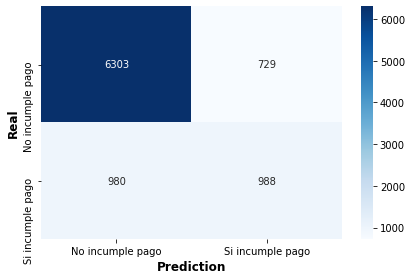

In [26]:
classes = ['No incumple pago','Si incumple pago']
plot_confusion_matrix(predict_test_1,y_test,dom='Test',classes=classes)

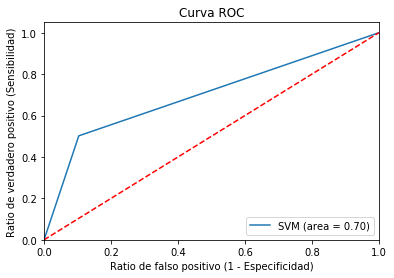

In [27]:
curva_roc = roc_auc_score(y_test, model_1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % curva_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo (1 - Especificidad)')
plt.ylabel('Ratio de verdadero positivo (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('Curva_roc')
plt.show()

**Variables importantes**

In [28]:
variables_importantes_2=model_1.feature_importances_

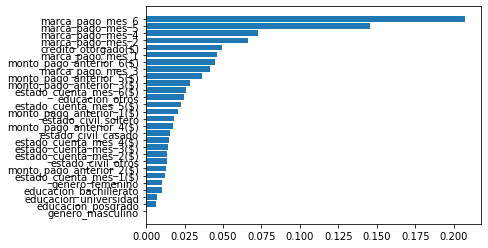

In [29]:
graf= pd.DataFrame(variables_importantes_2,X_train.columns)
graf.rename(columns={0:'valor'},inplace=True)
graf=graf.sort_values('valor')
plt.barh(graf.index,graf['valor'])
plt.show()

In [30]:
graf.sort_values('valor',ascending=False)

,valor
marca_pago_mes_6,0.207237
marca_pago_mes_5,0.145726
marca_pago_mes_4,0.072771
marca_pago_mes_2,0.066236
credito_otorgado($),0.049547
marca_pago_mes_1,0.045857
monto_pago_anterior_6($),0.044671
marca_pago_mes_3,0.041491
monto_pago_anterior_5($),0.036190
monto_pago_anterior_3($),0.028820


Vemos que la variable **"marca_pago_mes_6"** es la variable que aporta más al modelo.

In [31]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])

confusion_matrix_0 = confusion_matrix(y_train, predict_train_1, labels = labels)
confusion_matrix_1 = confusion_matrix(y_test, predict_test_1, labels = labels)
##
acc_0=(confusion_matrix_0[0][0]+confusion_matrix_0[1][1])/(confusion_matrix_0[0][0]+confusion_matrix_0[0][1]+confusion_matrix_0[1][0]+confusion_matrix_0[1][1])
acc=(confusion_matrix_1[0][0]+confusion_matrix_1[1][1])/(confusion_matrix_1[0][0]+confusion_matrix_1[0][1]+confusion_matrix_1[1][0]+confusion_matrix_1[1][1])
##
prec_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[0][1])
prec=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[0][1])
##
sens_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[1][0])
sens=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[1][0])
##
f1_score=2*(sens*prec)/(sens+prec)
f1_score_0=2*(sens_0*prec_0)/(sens_0+prec_0)
##
beta=2
f2_score=(1+beta**2)*((sens*prec)/(beta**2*prec+sens))
f2_score_0=(1+beta**2)*((sens_0*prec_0)/(beta**2*prec_0+sens_0))
##
curva_roc_0 = roc_auc_score(y_train, model_1.predict(X_train))

In [32]:
Tabla=pd.DataFrame({"Etapa":["Train","Test"],"Modelo":["Xgboost","Xgboost"],"Accuracy":[acc_0,acc],
                    "Precision":[prec_0,prec],"Sensibility":[sens_0,sens],
                    "F1 Score":[f1_score_0,f1_score],"F2 Score":[f2_score_0,f2_score],
                    "AUC":[curva_roc_0,curva_roc],"Gini":[2*curva_roc_0-1,2*curva_roc-1]})
Tabla

,Etapa,Modelo,Accuracy,Precision,Sensibility,F1 Score,F2 Score,AUC,Gini
0,Train,Xgboost,0.815429,0.601695,0.501928,0.547302,0.519144,0.703481,0.406961
1,Test,Xgboost,0.810111,0.575422,0.502033,0.536228,0.515174,0.699182,0.398364


### Ejercicio

Entrenar el dataset con gridsearchcv para el xgboost.